<a href="https://colab.research.google.com/github/KamilShape/emotion_recognition/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introduction**

In [13]:
#Libraries
import os
import cv2
from google.colab.patches import cv2_imshow
import shutil
#----------------visualisation-------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#----------------keras-----------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras

In [2]:
data_path = 'drive/MyDrive/faces/data'

In [3]:
people = ['smiling-person', 'anger-person', 'disgust-person', 'fear-person', 'surprise-person' ]

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
photos_number = []
for person in people:
  photos_number.append(len(os.listdir(f'{data_path}/{person}')))

In [6]:
photos_number

[1199, 1223, 1245, 1231, 1258]

### 1.1 Data visualisation

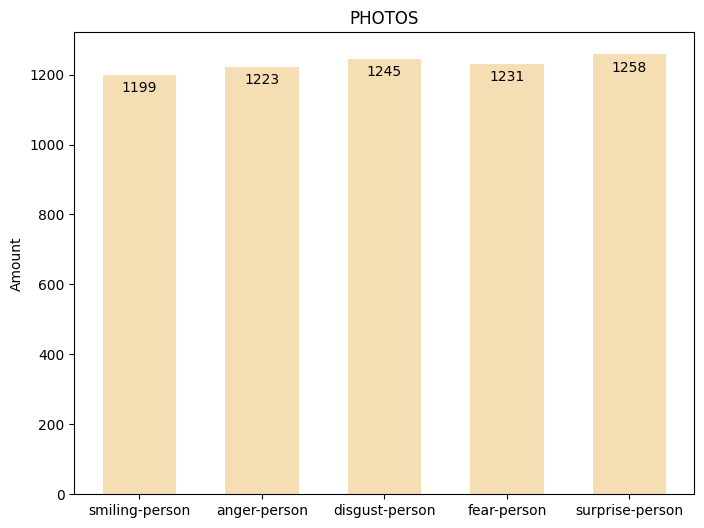

In [7]:
fig, ax = plt.subplots(figsize = (8,6))
ax.bar(people, photos_number, color='wheat', width=0.6)
ax.set_title('PHOTOS')
ax.set_ylabel('Amount')

for i in range(0, len(people)):
  ax.text(people[i], photos_number[i] - 50, horizontalalignment='center', s=photos_number[i] )

*Dataset is quite balanced.*

# **2. Train and test set**

In [8]:
train_path = 'drive/MyDrive/faces/train'

In [9]:
test_path = 'drive/MyDrive/faces/test'

In [11]:
def create_set(faces, path, new_path, set_size):
  for face in faces:
    files_folder = os.listdir(f'{path}/{face}')
    for n in range(0, round(len(files_folder)*set_size)):
      files_folder = os.listdir(f'{path}/{face}')
      photo_number = np.random.randint(len(files_folder))
      print(photo_number)
      os.makedirs(f'{new_path}/{face}', exist_ok=True)
      os.replace(f'{path}/{face}/{files_folder[photo_number]}', f'{new_path}/{face}/{files_folder[photo_number]}')

In [ ]:
#creating train set
create_set(people, data_path, train_path, 0.8)

In [ ]:
#creating test set
create_set(people, data_path, test_path, 1)

# **3. Face detection**

In [17]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
def face_recognition(photo, array):
  image = cv2.imread(photo)
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  face = face_classifier.detectMultiScale(gray_image, 1.3, 4)
  if len(face) > 0:
   for i, (x, y, w, h) in enumerate(face):
      cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 255), 2)
      face = image[y:y + h, x:x + w]
      array.append(face)

In [21]:
smiling_faces = []
anger_faces = []
disgust_faces = []
fear_faces = []
surprise_faces = []
def faces_array(array, photos, path):
  files_folder = os.listdir(f'{path}/{photos}')
  for i in range(0, len(files_folder)):
    img_path = f'{data_path}/{photos}/{files_folder[i]}'
    face_recognition(img_path, array)

In [25]:
# ['smiling-person', 'anger-person', 'disgust-person', 'fear-person', 'surprise-person' ]
faces_array(smiling_faces, "smiling-person", train_path)
faces_array(anger_faces, "anger-person", train_path)
faces_array(disgust_faces, "disgust-person", train_path)
faces_array(fear_faces, "fear-person", train_path)
faces_array(surprise_faces, "surprise-person", train_path)

In [26]:
faces = {
    'smiling-faces': smiling_faces,
    'anger-person' : anger_faces,
    'disgust-person' : disgust_faces,
    'fear_faces' : fear_faces,
    'surprise-person' : surprise_faces
}

# **4.Model**

In [ ]:
img_height = 64
img_width = 64
batch_size = 100

In [ ]:
#train and validation split
train_ds = keras.utils.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    seed=0,
    subset='training',
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode = 'categorical')

val_ds = keras.utils.image_dataset_from_directory(
    train_path,
    validation_split = 0.3,
    seed=0,
    subset='validation',
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode = 'categorical')

In [ ]:
model = Sequential()
model.add(layers.Rescaling(1./255))

model.add(layers.Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.RandomRotation(factor = (-1, 1), fill_mode='reflect', interpolation='bilinear',))

model.add(layers.Conv2D(32, (5,5), padding='same', activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Rescaling(scale=2, offset=0.0))

model.add(layers.MaxPool2D((2,2)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))